In [6]:
import math
import matplotlib.pyplot as plt
# calculus
import sympy as sym
import random
import numpy as np
import time

from scipy.special import gamma, gammaln
from mpmath import mp, gamma
mp.dps = 10  # You can set this to be high enough to handle the precision you need


In [7]:
def gamma_function(z):
    gamma_result = gamma(mp.mpf(str(z)))
    return gamma_result

In [8]:
def getPower(n, step, scheme, p_min, p_max):
    if scheme == 1:
        power_sum = 0
        for i in range(step):
            power_sum += p_min + ((p_max-p_min)/(step-1)) * (i)
        return power_sum / step
    else:
        return p_min + ((p_max-p_min)/(step-1)) * (n-1)

## Capture probability function

In [9]:
# only consider x capture
def P_cap(Px, Py, CR, gamma):
    # calculate power ratio threshold
    Pr = 10 ** (CR / 10)
    
    slope_1 = (Py * Pr / Px) ** (1 / gamma)

    if slope_1 >= 1 :
        result = (1 / ((Pr * Py / Px)**(1 / gamma)) / 2)
    elif slope_1 <= 1:
        result = 1 - ((Pr*Py/Px)**(1 / gamma)) / 2
    return result

## Gereral analytical

In [10]:

# Lmax: Retransmit limit
# TXOP: in ms
# Imax: total slots in worst case
def analytical(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    counter_power=0
    # setting ocw_n [ocw_min, 1st_retry_ocw....]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
        
    Ri = [RA_RU for _ in range(0,Imax+1)]
    M  = [0 for _ in range(0,Imax+1)]
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    M_i_s_C = [0 for _ in range(0,Imax+1)] # total success packet
    
    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0

                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            
            M[i] += M_i[i][n]
            
        #/** statistics */  
        for n in range (1,Lmax+1) : # n=1;n<=Lmax;n++){
            M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i])
            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
            M_i_s_C[i] += M_i_s[i][n]
            
#             counter_power += M_i_s[i][n] * 1 * n
            counter_power += M_i[i][n] * 1


        #/** performance metric */  
        #/** success probability */
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    success_probability = success_packet / sta_amount
    access_delay = (TXOP * counter_delay_slot) / success_packet
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    counter_power = counter_power / success_packet
#     counter_power = counter_power / sta_amount
    
    
    return Imax,success_probability,access_delay, utilization, through_put, counter_power  # ,sta*success_probability

## Random analytical (scheme 1)

In [11]:
# sta_amount: Total contend stations number
# RA_RU: RA_RU number reserved for UORA
# Lmax: Retransmit limit
# TXOP: Transaction Opportunity (time length in ms)
# ocw_min: minimum OCW
# ocw_max: maximum OCW
# CR: Capture Ratio (CR=infinite = no capture, CR=0 = always capture)

def analytical_random(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, CR, gamma, p_min, p_max):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    counter_power=0
    # setting ocw for each transmission [ocw_min, 1st_retry_ocw...ocw_max]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax: Reserved slot for transmission (total slots in worst case)
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
    # Ri: RA_RU number i-th slot, (Ri[i])
    Ri = [RA_RU for _ in range(0,Imax+1)]
    # M: Arrival number for i-th slot, (M[i])
    M  = [0 for _ in range(0,Imax+1)]
    # M_i: Arrival number for i-th slot and n-th transmission (M_i[n])
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Fail stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot (M_i_s_C[i])
    M_i_s_C = [0 for _ in range(0,Imax+1)]
    
    capture_prob = 0
    for n1 in range(1, Lmax+1):
        for n2 in range(1, Lmax+1):
            # P is the power of two station
            P1 = getPower(n=n1, step=Lmax, scheme=2, p_min=p_min, p_max=p_max)
            P2 = getPower(n=n2, step=Lmax, scheme=2, p_min=p_min, p_max=p_max)
            capture_prob += P_cap(P1, P2, CR, gamma) * (1 / Lmax) * (1 / Lmax)

    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0
                    
                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            M[i] += M_i[i][n]
            
        #/** statistics */  
        for n in range (1, Lmax+1):
            #/** Calculate capture probability for slot i */
            if (M[i] >= 2):
                M_i_s[i][n] += M_i[i][n] * math.exp(-M[i] / Ri[i])
                # gamma
#                 M_i_s[i][n] += (capture_prob * 2) * ((M_i[i][n] / M[i]) ** 2) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
#                 M_i_s[i][n] += (capture_prob * 2) * (2 * M_i[i][n] / M[i]) * ((M[i] - M_i[i][n]) / M[i]) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
                # y=1
#                 M_i_s[i][n] += capture_prob * (2 * M_i[i][n] / M[i]) * ((M[i] - M_i[i][n]) / M[i]) * (M[i] * (M[i]-1) / 2) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
                M_i_s[i][n] += capture_prob * (2 * M_i[i][n] / M[i]) * ((M[i] - M_i[i][n]) / M[i]) * (M[i] * (M[i]-1) / 2) / (Ri[i] ** (2-1)) * ((1 - 1/ Ri[i]) ** (M[i]-2))
                # y=2
                M_i_s[i][n] += (capture_prob * 2) * ((M_i[i][n] / M[i]) ** 2) * (M[i] * (M[i]-1) / 2) / (Ri[i] ** (2-1)) * ((1 - 1/ Ri[i]) ** (M[i]-2))
            if (M[i] < 2):
                M_i_s[i][n] += M_i[i][n] * ((1 - 1/ Ri[i]) ** (M[i]-1))

            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
            M_i_s_C[i] += M_i_s[i][n]
        
            counter_power += getPower(n=n, step=Lmax, scheme=1, p_min=p_min, p_max=p_max) * M_i[i][n]
        #/** performance metric */  
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    #/** success probability */
    success_probability = success_packet / sta_amount
        
    access_delay = (TXOP * counter_delay_slot) / success_packet
#     Throughput 
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    # sta*success_probability 來算 grouping的Ds
    if success_packet != 0:
        counter_power = counter_power / success_packet
    
    return Imax,success_probability,access_delay, utilization, through_put, counter_power  # ,sta*success_probability

## Transmit-based analytical (scheme 2)

In [12]:
# sta_amount: Total contend stations number
# RA_RU: RA_RU number reserved for UORA
# Lmax: Retransmit limit
# TXOP: Transaction Opportunity (time length in ms)
# ocw_min: minimum OCW
# ocw_max: maximum OCW
# CR: Capture Ratio (CR=infinite = no capture, CR=0 = always capture)

def analytical_rampup(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, CR, gamma, p_min, p_max):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    counter_power=0
    # setting ocw for each transmission [ocw_min, 1st_retry_ocw...ocw_max]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax: Reserved slot for transmission (total slots in worst case)
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
    # Ri: RA_RU number i-th slot, (Ri[i])
    Ri = [RA_RU for _ in range(0,Imax+1)]
    # M: Arrival number for i-th slot, (M[i])
    M  = [0 for _ in range(0,Imax+1)]
    # M_i: Arrival number for i-th slot and n-th transmission (M_i[n])
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Fail stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot (M_i_s_C[i])
    M_i_s_C = [0 for _ in range(0,Imax+1)]
    
    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0
                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            M[i] += M_i[i][n]
            

        #/** statistics */  
        for n in range (1, Lmax+1):
            #/** Calculate capture probability for slot i */
            if M[i] > 0:
                capture_prob_n_k = 0
                capture_prob_n2 = 0
                Pn = getPower(n=n, step=Lmax, scheme=2, p_min=p_min, p_max=p_max)
                
                capture_prob_n2 += P_cap(Pn, Pn, CR, gamma) * 2
                # calculate the capture prob. when n-th with k-th (K!=n)
                for k in range(1, Lmax+1):
                    Pk = getPower(n=k, step=Lmax, scheme=2, p_min=p_min, p_max=p_max)
                    if (n != k):
                        if (M[i] > M_i[i][n]):
#                             capture_prob_n_k += P_cap(Pn, Pk, CR, gamma) * (M_i[i][k] / (M[i] - M_i[i][n]))
                            capture_prob_n_k += P_cap(Pn, Pk, CR, gamma) * (M_i[i][k] / (M[i] - M_i[i][n]))
            
            if (M[i] >= 2):
                M_i_s[i][n] += M_i[i][n] * math.exp(-M[i] / Ri[i])
                M_i_s[i][n] += capture_prob_n2 * ((M_i[i][n] / M[i]) ** 2) * (M[i] * (M[i]-1) / 2) / (Ri[i] ** (2-1)) * ((1 - 1/ Ri[i]) ** (M[i]-2))
                M_i_s[i][n] += capture_prob_n_k * (2 * M_i[i][n] / M[i]) * ((M[i] - M_i[i][n]) / M[i]) * (M[i] * (M[i]-1) / 2) / (Ri[i] ** (2-1)) * ((1 - 1/ Ri[i]) ** (M[i]-2))
            if (M[i] < 2):
#                 M_i_s[i][n] += M_i[i][n] * math.exp(-M[i] / Ri[i])
                M_i_s[i][n] += M_i[i][n] * ((1 - 1/ Ri[i]) ** (M[i]-2))

            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
            M_i_s_C[i] += M_i_s[i][n]
        
            counter_power += getPower(n=n, step=Lmax, scheme=2, p_min=p_min, p_max=p_max) * M_i[i][n]
        #/** performance metric */  
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    #/** success probability */
    success_probability = success_packet / sta_amount
        
    access_delay = (TXOP * counter_delay_slot) / success_packet
#     Throughput 
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    # sta*success_probability 來算 grouping的Ds
    if success_packet != 0:
        counter_power = counter_power / success_packet
    
    return Imax,success_probability,access_delay, utilization, through_put, counter_power  # ,sta*success_probability

# Scenario I
Scenario III was designed to investigate the impact of transmit power levels $N$ on access success probability.

- Figure: $P_s$ for [$N=1$, $N=2$, $N=3$]
- Parameters: $R=128, C=3dB, L_{max}=5, OCW_{min}=7, OCW_{max}=31$
- x-axis: M STAs (10-200)

In [13]:
# R = [148]
R = [9,18,37,74,148]
Lmax = 5
ocw_min = 7
ocw_max = 31
CR = 3
N = 4
T_slot = 5.673

p_min = 10
p_max = 250

# sta_max = 200

sta_max = 1000
m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_ramp  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

power_list = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_random = [ [0] * (sta_max) for _ in range(0, len(R))]
power_list_ramp = [ [0] * (sta_max) for _ in range(0, len(R))]

# General
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max)
        ps_list[idx][sta-1] = Ps
        da_list[idx][sta-1] = Da
        u_list[idx][sta-1] = U
        power_list[idx][sta-1] = power

# Random
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_random(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, gamma=2, p_min=p_min, p_max=p_max)
        ps_list_random[idx][sta-1] = Ps
        da_list_random[idx][sta-1] = Da
        u_list_random[idx][sta-1] = U
        power_list_random[idx][sta-1] = power

# RampUp
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp,power = analytical_rampup(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=T_slot, ocw_min=ocw_min, ocw_max=ocw_max, CR=CR, gamma=2, p_min=p_min, p_max=p_max)
        ps_list_ramp[idx][sta-1] = Ps
        da_list_ramp[idx][sta-1] = Da
        u_list_ramp[idx][sta-1] = U
        power_list_ramp[idx][sta-1] = power
        

In [14]:
m_list_simu = np.concatenate([np.arange(1, 11, 1), np.arange(20, 110, 10), np.arange(200, 1100, 100)])

### Genral simu result

In [22]:
ps_list_simu_9 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9997999999999999, 0.9907000000000015, 0.9026666666666622, 0.7092500000000005, 0.5145800000000003, 0.37571666666666687, 0.2789285714285714, 0.21583749999999988, 0.16768888888888914, 0.13787999999999997, 0.04509499999999981, 0.025990000000000058, 0.018182499999999973, 0.013307999999999915, 0.010820000000000005, 0.008759999999999987, 0.007312499999999995, 0.006397777777777762, 0.005415999999999951]
da_list_simu_9 = [5.672999999999856, 6.696976499999851, 7.410828999999852, 8.057078249999888, 8.812438199999981, 9.906949, 10.925387571428525, 11.881389375000047, 12.517159333333293, 13.54258560000006, 23.73256768320439, 32.81551105358449, 39.24668388758677, 43.74820281429042, 47.562319458933366, 51.032473824096265, 54.140734905131175, 57.1298891142195, 59.304765028487246, 69.66799627856699, 72.5954199926992, 74.1330774332835, 75.32684205642703, 76.22168509140042, 76.70414479077618, 77.19221574771092, 77.59827048311729, 78.11686413528179]
t_list_simu_9 = [0.06666666666666801, 0.13333333333333602, 0.19999999999999718, 0.26666666666667205, 0.3333333333333318, 0.39999999999999436, 0.46666666666665557, 0.5333333333333441, 0.6000000000000113, 0.6665333333333303, 1.320933333333328, 1.8053333333333244, 1.8913333333333342, 1.7152666666666656, 1.5028666666666675, 1.3016666666666685, 1.1511333333333336, 1.0061333333333324, 0.9191999999999996, 0.6012666666666674, 0.5198000000000005, 0.48486666666666545, 0.4435999999999977, 0.432799999999998, 0.4087999999999979, 0.38999999999999746, 0.3838666666666643, 0.3610666666666642]
u_list_simu_9 = [0.007407407407407279, 0.014814814814814559, 0.02222222222222215, 0.029629629629629117, 0.0370370370370375, 0.0444444444444443, 0.051851851851851004, 0.059259259259258235, 0.06666666666666801, 0.07405925925926019, 0.14677037037037183, 0.20059259259259238, 0.2101481481481481, 0.19058518518518486, 0.16698518518518504, 0.1446296296296296, 0.127903703703704, 0.11179259259259267, 0.10213333333333352, 0.06680740740740743, 0.057755555555555595, 0.0538740740740741, 0.049288888888888924, 0.04808888888888895, 0.04542222222222232, 0.04333333333333328, 0.04265185185185183, 0.04011851851851858]
power_list_simu_9 = [1.0, 1.13, 1.2173333333333327, 1.2985, 1.3836000000000026, 1.5081666666666638, 1.6135714285714307, 1.7075, 1.7802222222222228, 1.873299999999997, 2.8181477124182948, 4.039608728023354, 6.060868492374349, 9.109957795993283, 13.023155254381235, 18.050593939304292, 23.75446347621425, 31.02526823122986, 38.215261365412076, 121.44026488715515, 214.10900477577934, 310.3051695138194, 435.81266797091746, 534.344793983793, 674.9507478632476, 804.436886779883, 931.0637362637382, 1104.653499278498] 

ps_list_simu_18 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9996499999999998, 0.9864999999999996, 0.9145000000000012, 0.7429799999999992, 0.5639499999999997, 0.41877142857142635, 0.31094999999999984, 0.23595555555555509, 0.1823299999999994, 0.04539499999999999, 0.02402000000000004, 0.01527249999999999, 0.010379999999999919, 0.007260000000000011, 0.005054285714285698, 0.003509999999999999, 0.00228666666666666, 0.0016179999999999808]
da_list_simu_18 = [5.672999999999856, 6.047417999999852, 6.368887999999858, 6.577843499999907, 6.95509799999996, 7.163107999999967, 7.528881428571299, 7.9003616250000395, 8.215764666666626, 8.704651200000036, 12.633288297368454, 17.620668409873495, 21.97278759734812, 25.3272549428786, 27.57065472174528, 29.448927686060095, 31.18957891667271, 32.90854056604097, 34.33642734913023, 43.10441705113664, 44.86251912520758, 45.17270244328908, 45.297212104760796, 45.00989266428459, 44.2470362499989, 43.34171999999893, 40.11945599999906, 37.44179999999917]
t_list_simu_18 = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125, 1.25, 2.499125, 3.699375, 4.5725, 4.643625, 4.229625, 3.66425, 3.1095, 2.6545, 2.279125, 1.134875, 0.90075, 0.763625, 0.64875, 0.5445, 0.44225, 0.351, 0.25725, 0.20225]
u_list_simu_18 = [0.0069444444444445785, 0.013888888888889157, 0.02083333333333324, 0.027777777777778314, 0.03472222222222164, 0.04166666666666648, 0.048611111111111965, 0.05555555555555663, 0.0625, 0.06944444444444328, 0.13884027777777544, 0.2055208333333348, 0.254027777777778, 0.2579791666666668, 0.23497916666666666, 0.20356944444444453, 0.1727499999999998, 0.14747222222222212, 0.12661805555555564, 0.06304861111111108, 0.05004166666666674, 0.0424236111111112, 0.03604166666666668, 0.03025000000000001, 0.024569444444444477, 0.019500000000000087, 0.014291666666666833, 0.011236111111111252]
power_list_simu_18 = [1.0, 1.063, 1.1186666666666656, 1.15475, 1.219199999999999, 1.2555000000000005, 1.3135714285714313, 1.37175, 1.4239999999999908, 1.4986000000000061, 2.066690643274855, 2.798479556229212, 3.7593192265611077, 5.471898035591947, 7.956694813189961, 11.321568307870352, 15.832035874514423, 21.433906413611094, 28.176925555846843, 121.352795594928, 236.24257278832226, 381.14338727938616, 580.5449134199127, 855.1083333333352, 1210.251388888888, 1694.4952380952348, 2232.7714285714283, 2688.214285714283] 

ps_list_simu_37 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995000000000002, 0.9930600000000015, 0.9630333333333317, 0.8740857142857129, 0.7281625000000003, 0.564455555555556, 0.42500000000000077, 0.022249999999999992, 0.0014533333333333375, 9.250000000000004e-05, 6e-06, 0.0, 0.0, 0.0, 0.0, 0.0]
da_list_simu_37 = [5.672999999999856, 5.7807869999998545, 5.9642139999998625, 6.186406499999879, 6.2425691999999104, 6.417108499999925, 6.582300857142723, 6.687048749999978, 6.8365953333332845, 6.976088100000008, 8.430361650000052, 10.043479199999974, 11.851772831578979, 13.886956625190507, 15.975882322967374, 17.35897789378024, 18.164687328644906, 18.365570503259654, 18.435974243912934, 17.123414323101915, 5.831843999999975, 0.5956650000000001, 0.051057000000000005, 0.0, 0.0, 0.0, 0.0, 0.0]
t_list_simu_37 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 7.996000000000001, 9.93060000000002, 11.556400000000066, 12.237200000000007, 11.650600000000004, 10.160200000000009, 8.499999999999991, 0.8899999999999993, 0.0872000000000004, 0.007400000000000004, 0.0006000000000000001, 0.0, 0.0, 0.0, 0.0, 0.0]
u_list_simu_37 = [0.005405405405405471, 0.010810810810810942, 0.016216216216216387, 0.021621621621621883, 0.02702702702702728, 0.032432432432432774, 0.03783783783783734, 0.043243243243243766, 0.048648648648649366, 0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.2161081081081101, 0.268394594594591, 0.31233513513513433, 0.3307351351351353, 0.314881081081081, 0.2745999999999998, 0.22972972972972971, 0.024054054054054124, 0.0023567567567567426, 0.0002, 1.6216216216216218e-05, 0.0, 0.0, 0.0, 0.0, 0.0]
power_list_simu_37 = [1.0, 1.019, 1.0513333333333323, 1.0905, 1.1003999999999978, 1.131166666666668, 1.1602857142857184, 1.17875, 1.2051111111111, 1.229700000000009, 1.486050000000001, 1.7703999999999993, 2.0918152046783605, 2.484724657223259, 3.0190648492248533, 3.8197628155089958, 5.164025793578392, 7.275771816300664, 10.316689939716984, 292.71356810134336, 471.7680000000001, 73.92, 7.494, 0.0, 0.0, 0.0, 0.0, 0.0] 

ps_list_simu_74 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998857142857142, 0.9995250000000003, 0.9987555555555548, 0.9945100000000032, 0.43009000000000025, 0.09580333333333352, 0.023112499999999928, 0.005791999999999918, 0.0013616666666666768, 0.00034428571428571445, 9.375000000000006e-05, 3e-05, 8e-06]
da_list_simu_74 = [5.672999999999856, 5.763767999999854, 5.846971999999856, 5.868718499999871, 5.953246199999879, 6.060654999999886, 6.131702571428436, 6.181442624999935, 6.2699256666665875, 6.324827699999938, 7.035370950000035, 7.754612800000025, 8.52822090000004, 9.270816599999996, 10.173580000000007, 10.965294027731087, 11.939923098076946, 12.927792915116274, 14.032682844527796, 18.430959688136696, 17.622514990991956, 17.305197642544258, 16.28559427348482, 10.108340499999946, 3.7158149999999885, 1.3132995000000003, 0.37725450000000005, 0.13615200000000002]
t_list_simu_74 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 13.998400000000002, 15.992400000000005, 17.977600000000006, 19.890199999999997, 17.203600000000005, 5.748200000000007, 1.8490000000000015, 0.5791999999999987, 0.16339999999999968, 0.04820000000000008, 0.014999999999999979, 0.005400000000000001, 0.0015999999999999999]
u_list_simu_74 = [0.0027027027027027354, 0.005405405405405471, 0.008108108108108194, 0.010810810810810942, 0.01351351351351364, 0.016216216216216387, 0.01891891891891867, 0.021621621621621883, 0.024324324324324683, 0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.18916756756756956, 0.21611351351351546, 0.2429405405405462, 0.268786486486484, 0.23248108108108081, 0.07767837837837832, 0.02498648648648658, 0.007827027027027053, 0.0022081081081081026, 0.0006513513513513483, 0.00020270270270270272, 7.297297297297297e-05, 2.1621621621621624e-05]
power_list_simu_74 = [1.0, 1.016, 1.0306666666666664, 1.0345, 1.0493999999999983, 1.0683333333333347, 1.0808571428571458, 1.089625, 1.1052222222222159, 1.1149000000000056, 1.2401500000000032, 1.3669333333333331, 1.503299999999999, 1.6341999999999972, 1.7933333333333354, 1.9334798319327733, 2.107128846153848, 2.2852025017618067, 2.501920401477214, 10.01707848277383, 51.94827965526793, 242.05190662565622, 1066.875781277057, 1425.3968333333332, 708.9133333333334, 287.8665, 107.9415, 39.984] 

ps_list_simu_148 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9955300000000031, 0.8035466666666659, 0.4298099999999999, 0.2033899999999989, 0.09729666666666681, 0.04700714285714272, 0.023227499999999957, 0.011787777777777756, 0.005794999999999954]
da_list_simu_148 = [5.672999999999856, 5.712710999999856, 5.759985999999858, 5.782205249999861, 5.82957479999987, 5.823334499999872, 5.9153181428570045, 5.970123374999907, 5.956019666666558, 6.015081899999913, 6.384110550000015, 6.700947600000007, 7.088129850000018, 7.418128260000028, 7.791014550000005, 8.166445585714301, 8.508578137500036, 8.870933133333338, 9.329135040000002, 14.042745440398424, 17.857121723019524, 18.390666271752412, 18.037540930091488, 17.642934747579837, 17.39780005029307, 17.33293247673548, 17.138792521534377, 16.90111083783717]
t_list_simu_148 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 39.821199999999806, 48.21280000000003, 34.38480000000003, 20.339000000000024, 11.6756, 6.581000000000009, 3.7164000000000024, 2.1218000000000004, 1.1589999999999991]
u_list_simu_148 = [0.0013513513513513677, 0.0027027027027027354, 0.004054054054054097, 0.005405405405405471, 0.00675675675675682, 0.008108108108108194, 0.009459459459459335, 0.010810810810810942, 0.012162162162162342, 0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.26906216216215917, 0.3257621621621624, 0.23232972972972965, 0.1374256756756756, 0.07888918918918905, 0.044466216216216124, 0.025110810810810767, 0.014336486486486572, 0.007831081081081104]
power_list_simu_148 = [1.0, 1.007, 1.015333333333333, 1.01925, 1.027599999999999, 1.0265000000000013, 1.0427142857142886, 1.052375, 1.049888888888885, 1.0603000000000045, 1.1253500000000065, 1.1812000000000074, 1.2494500000000013, 1.3076199999999996, 1.3733499999999979, 1.4395285714285735, 1.499837499999999, 1.5637111111111137, 1.6444799999999993, 2.4980754985742992, 4.384692764556156, 9.945078703301634, 23.01841642029667, 50.3526637961059, 107.77946296372629, 226.00739166103918, 475.80740409763513, 1087.4394179459432] 

### random simu result

In [23]:
ps_list_simu_9_random = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9992500000000002, 0.9879333333333336, 0.9230250000000011, 0.7981599999999995, 0.6358999999999996, 0.4930857142857142, 0.38296250000000015, 0.3034444444444443, 0.24201999999999974, 0.07112000000000009, 0.040236666666666726, 0.02739499999999995, 0.020225999999999834, 0.015893333333333384, 0.013027142857142834, 0.011103749999999976, 0.009439999999999957, 0.008329999999999964]
da_list_simu_9_random = [5.672999999999856, 6.169387499999859, 6.671447999999891, 7.315333499999955, 7.741375800000003, 8.288252999999955, 8.725073999999962, 9.420725625000024, 10.017887666666622, 10.674884100000032, 17.442131155263272, 25.408280786064996, 32.16958781094898, 37.65150383227682, 41.90369156958456, 45.4270146408241, 48.41499785123372, 51.15231164559653, 53.848591085858715, 67.4912731607322, 70.89849857849529, 72.83593067870733, 74.05195920848753, 74.93754626082986, 75.71013271901161, 76.35771870711791, 76.81825628168852, 77.21484055046236]
t_list_simu_9_random = [0.06666666666666801, 0.13333333333333602, 0.19999999999999718, 0.26666666666667205, 0.3333333333333318, 0.39999999999999436, 0.46666666666665557, 0.5333333333333441, 0.6000000000000113, 0.6666666666666636, 1.3323333333333276, 1.975866666666667, 2.461400000000003, 2.6605333333333236, 2.5435999999999983, 2.301066666666667, 2.0424666666666673, 1.8206666666666627, 1.613466666666665, 0.9482666666666675, 0.804733333333333, 0.7305333333333344, 0.6742000000000007, 0.6357333333333349, 0.6079333333333349, 0.5922000000000014, 0.5664000000000012, 0.5553333333333343]
u_list_simu_9_random = [0.007407407407407279, 0.014814814814814559, 0.02222222222222215, 0.029629629629629117, 0.0370370370370375, 0.0444444444444443, 0.051851851851851004, 0.059259259259258235, 0.06666666666666801, 0.074074074074075, 0.14803703703703885, 0.21954074074074365, 0.27348888888888884, 0.29561481481481444, 0.28262222222222216, 0.2556740740740739, 0.2269407407407411, 0.20229629629629617, 0.1792740740740738, 0.10536296296296328, 0.08941481481481488, 0.08117037037037034, 0.0749111111111112, 0.07063703703703716, 0.06754814814814838, 0.06580000000000014, 0.06293333333333344, 0.06170370370370385]
power_list_simu_9_random = [130.06, 137.035, 146.4433333333332, 158.075, 164.42, 173.8683333333332, 178.5799999999998, 187.2175, 197.49222222222235, 207.089, 290.6155789473684, 386.13957637432867, 501.5712832155741, 663.9378538134158, 910.6584212763302, 1240.4188270350849, 1650.499957060379, 2123.374970787202, 2699.8631993298973, 9586.913957210756, 17006.333607538676, 25233.982100439614, 34277.60116669437, 44362.99698525494, 53920.882841145794, 63560.71225438452, 75424.94533898945, 85425.25823643035]


ps_list_simu_18_random = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9997, 0.9956000000000017, 0.9636000000000076, 0.8749833333333326, 0.7395000000000007, 0.5845999999999998, 0.46128888888888836, 0.3589700000000003, 0.07528999999999997, 0.03810666666666677, 0.025729999999999975, 0.01850999999999992, 0.013640000000000048, 0.009947142857142849, 0.007547499999999993, 0.005666666666666656, 0.003938999999999964]
da_list_simu_18_random = [5.672999999999856, 5.846026499999864, 6.05119999999988, 6.272919749999922, 6.412759199999946, 6.605262999999906, 6.772751571428534, 7.048702500000019, 7.274676999999993, 7.508782800000038, 9.84690975000004, 12.970316368719205, 16.59515105860241, 20.33497380067004, 23.51940301143536, 25.95067340414923, 27.95520129020899, 29.623120973088405, 31.140453614128944, 41.46947952361111, 44.342396538715825, 45.04086541981156, 45.2789709838277, 45.35675651790599, 45.378238998916615, 45.3346223880941, 45.29323199999885, 44.65785599999888]
t_list_simu_18_random = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125, 1.25, 2.5, 3.748875, 4.978, 6.0225, 6.562375, 6.470625, 5.846, 5.1895, 4.487125, 1.88225, 1.429, 1.2865, 1.156875, 1.023, 0.870375, 0.75475, 0.6375, 0.492375]
u_list_simu_18_random = [0.0069444444444445785, 0.013888888888889157, 0.02083333333333324, 0.027777777777778314, 0.03472222222222164, 0.04166666666666648, 0.048611111111111965, 0.05555555555555663, 0.0625, 0.06944444444444328, 0.13888888888888656, 0.2082708333333358, 0.2765555555555516, 0.33458333333333395, 0.3645763888888886, 0.35947916666666685, 0.3247777777777778, 0.2883055555555554, 0.24928472222222203, 0.10456944444444448, 0.0793888888888886, 0.07147222222222202, 0.06427083333333344, 0.05683333333333347, 0.0483541666666667, 0.041930555555555665, 0.03541666666666672, 0.027354166666666666]
power_list_simu_18_random = [127.18, 136.335, 139.40333333333314, 144.6225, 145.838, 149.96500000000006, 155.0871428571429, 158.98875, 165.55555555555574, 170.16, 217.953, 274.16154844006536, 341.4448001209713, 426.42793281748294, 545.3292492082423, 720.0412062248931, 984.9902941436434, 1306.1286189175228, 1737.1934377936711, 9039.235336111964, 18071.120207827167, 26729.585086044717, 37288.78699303474, 51812.529981851476, 74033.75385841946, 99902.53261703273, 136550.1794780037, 205330.21542295752]


ps_list_simu_37_random = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999600000000001, 0.9995333333333334, 0.996685714285713, 0.9848999999999972, 0.941377777777777, 0.8567700000000003, 0.07607999999999991, 0.006276666666666648, 0.00044000000000000034, 4.2000000000000025e-05, 3.3333333333333337e-06, 0.0, 0.0, 0.0, 0.0]
da_list_simu_37_random = [5.672999999999856, 5.760931499999859, 5.871554999999872, 5.92403024999989, 5.9804765999999026, 6.092801999999883, 6.241110428571347, 6.295611749999974, 6.406707999999943, 6.517709700000009, 7.406385150000037, 8.4151391, 9.537731250000064, 10.766503050000022, 12.212236442288273, 13.714784757021077, 15.32263886044207, 16.724541935943872, 17.787360486795528, 17.70611934275062, 14.772046264285693, 2.745731999999993, 0.27797700000000003, 0.045384, 0.0, 0.0, 0.0, 0.0]
t_list_simu_37_random = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 9.999600000000001, 11.994399999999997, 13.953599999999993, 15.758399999999956, 16.944799999999976, 17.135399999999994, 3.043199999999996, 0.3765999999999985, 0.03519999999999996, 0.0042000000000000015, 0.0004, 0.0, 0.0, 0.0, 0.0]
u_list_simu_37_random = [0.005405405405405471, 0.010810810810810942, 0.016216216216216387, 0.021621621621621883, 0.02702702702702728, 0.032432432432432774, 0.03783783783783734, 0.043243243243243766, 0.048648648648649366, 0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21621621621621823, 0.27025945945945506, 0.32417297297297165, 0.3771243243243271, 0.4259027027027047, 0.4579675675675671, 0.4631189189189185, 0.08224864864864848, 0.010178378378378428, 0.0009513513513513481, 0.00011351351351351351, 1.0810810810810812e-05, 0.0, 0.0, 0.0, 0.0]
power_list_simu_37_random = [129.46, 133.035, 134.08999999999992, 135.3775, 136.122, 139.89000000000013, 143.4900000000001, 144.425, 147.49333333333325, 150.947, 170.2705, 192.49166666666687, 219.017, 246.35968333333358, 280.3701884144903, 317.06674093965364, 361.49740378370814, 424.19634683817435, 520.3676946909185, 8877.668890442348, 116659.85140528853, 252214.61847389562, 316878.0, 388520.0, 388520.0, 388520.0, 388520.0, 388520.0]


ps_list_simu_74_random = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99998, 0.8586150000000015, 0.2873199999999996, 0.0772125000000001, 0.021809999999999878, 0.006166666666666667, 0.001755714285714278, 0.0005149999999999965, 0.00013222222222222192, 4.500000000000003e-05]
da_list_simu_74_random = [5.672999999999856, 5.732566499999857, 5.7429669999998625, 5.823334499999871, 5.855670599999886, 5.890464999999873, 5.9712377142856115, 5.9679959999999115, 6.02787766666657, 6.083725199999966, 6.54834390000001, 6.993107099999998, 7.459711350000033, 7.9327828199999955, 8.440573050000008, 8.975496428571414, 9.516457500000065, 10.13928986666669, 10.754963704897964, 17.77090078450831, 18.372749286844506, 17.66745960412782, 17.298947248859793, 16.602876445238078, 12.386617299999962, 5.7406032499999755, 1.8692535000000003, 0.7488360000000002]
t_list_simu_74_random = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 19.999599999999997, 34.34459999999999, 17.239200000000015, 6.177000000000006, 2.180999999999997, 0.7400000000000003, 0.24579999999999894, 0.08240000000000046, 0.02379999999999995, 0.009]
u_list_simu_74_random = [0.0027027027027027354, 0.005405405405405471, 0.008108108108108194, 0.010810810810810942, 0.01351351351351364, 0.016216216216216387, 0.01891891891891867, 0.021621621621621883, 0.024324324324324683, 0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891891891891912, 0.21621621621621823, 0.24324324324324892, 0.27026486486486045, 0.46411621621621574, 0.23296216216216203, 0.08347297297297301, 0.029472972972973133, 0.010000000000000031, 0.0033216216216216386, 0.0011135135135135065, 0.0003216216216216212, 0.00012162162162162163]
power_list_simu_74_random = [130.72, 130.405, 132.26333333333332, 134.06, 133.334, 134.6733333333335, 135.65142857142848, 137.345, 137.48555555555532, 139.538, 150.239, 159.68300000000002, 170.918, 181.49020000000021, 193.10650000000024, 206.20057142857127, 218.18225, 233.05088888888855, 246.34970204081637, 515.398592487275, 2054.367512618626, 8428.776736795124, 33149.97673006755, 140828.18511499852, 334777.1540923639, 465077.21315529174, 566312.7232142857, 642684.3181818182]


ps_list_simu_148_random = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99999, 0.9934833333333385, 0.8568925000000005, 0.5403299999999986, 0.289065, 0.14908285714285713, 0.07861500000000007, 0.04110999999999994, 0.022126999999999897]
da_list_simu_148_random = [5.672999999999856, 5.695691999999857, 5.7202749999998606, 5.7325664999998605, 5.775113999999874, 5.802533499999859, 5.815635428571307, 5.824752749999889, 5.870294333333218, 5.88006449999991, 6.118046849999994, 6.3074304999999935, 6.558697125000017, 6.794211720000014, 7.015515449999994, 7.24142241428571, 7.468079025000033, 7.71471270000002, 7.935505859999987, 10.78814454723619, 14.547675987633298, 17.775180464136053, 18.633094852668727, 18.385564479325275, 17.97218252318477, 17.689847004524104, 17.409419723154105, 17.355111762947857]
t_list_simu_148_random = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 39.9996, 59.609000000000066, 68.55139999999997, 54.03300000000001, 34.68779999999995, 20.871600000000004, 12.578400000000002, 7.399800000000007, 4.425399999999999]
u_list_simu_148_random = [0.0013513513513513677, 0.0027027027027027354, 0.004054054054054097, 0.005405405405405471, 0.00675675675675682, 0.008108108108108194, 0.009459459459459335, 0.010810810810810942, 0.012162162162162342, 0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.27026756756756315, 0.40276351351351286, 0.4631851351351351, 0.3650878378378375, 0.23437702702702704, 0.14102432432432432, 0.0849891891891891, 0.04999864864864854, 0.029901351351351316]
power_list_simu_148_random = [135.22, 131.33, 130.4233333333333, 129.91, 129.724, 133.60833333333343, 134.32285714285712, 133.7025, 133.34777777777765, 134.313, 139.9165, 144.87833333333313, 150.79425, 155.62240000000003, 159.73750000000007, 165.97385714285716, 170.605, 177.1436666666668, 181.6456, 247.165368844221, 336.93611770361764, 516.6219808212257, 982.9142421454934, 2032.2333468682295, 4156.271303280805, 8143.7369636389885, 15927.938962810582, 30528.954745990774]

### Ramp Up simu result

In [24]:
ps_list_simu_9_ramp = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9993000000000003, 0.9841999999999994, 0.9106749999999999, 0.7684799999999999, 0.610716666666667, 0.4699857142857142, 0.3665374999999998, 0.2889666666666666, 0.23182000000000022, 0.06756499999999999, 0.03874666666666674, 0.026249999999999947, 0.019429999999999944, 0.015600000000000046, 0.012392857142857105, 0.010543749999999965, 0.009151111111111077, 0.008003999999999976]
da_list_simu_9_ramp = [5.672999999999856, 6.265828499999859, 6.7130499999998925, 7.2302384999999445, 7.9149695999999965, 8.427241499999965, 9.20727899999996, 9.685938375000031, 10.263717666666631, 10.98236070000006, 18.23547366491239, 26.030857815305065, 32.9429136233403, 38.264540982076426, 42.38988940113486, 45.797170597885916, 48.854296962343014, 51.637538590391365, 54.1296512162281, 67.69034306516478, 71.08447922234768, 72.90932974638102, 74.09573502968631, 75.01591647333953, 75.84755918830088, 76.4214490200426, 76.85827968599332, 77.37371340848321]
t_list_simu_9_ramp = [0.06666666666666801, 0.13333333333333602, 0.19999999999999718, 0.26666666666667205, 0.3333333333333318, 0.39999999999999436, 0.46666666666665557, 0.5333333333333441, 0.6000000000000113, 0.6666666666666636, 1.3323999999999943, 1.9683999999999988, 2.4284666666666674, 2.5616000000000003, 2.442866666666668, 2.193266666666668, 1.9548666666666674, 1.7337999999999956, 1.5454666666666637, 0.9008666666666646, 0.7749333333333337, 0.7000000000000017, 0.6476666666666687, 0.6240000000000028, 0.5783333333333351, 0.5623333333333344, 0.5490666666666677, 0.533600000000001]
u_list_simu_9_ramp = [0.007407407407407279, 0.014814814814814559, 0.02222222222222215, 0.029629629629629117, 0.0370370370370375, 0.0444444444444443, 0.051851851851851004, 0.059259259259258235, 0.06666666666666801, 0.074074074074075, 0.14804444444444628, 0.2187111111111138, 0.2698296296296299, 0.2846222222222218, 0.2714296296296293, 0.2436962962962964, 0.21720740740740765, 0.19264444444444448, 0.171718518518518, 0.10009629629629653, 0.08610370370370368, 0.07777777777777783, 0.07196296296296296, 0.06933333333333354, 0.06425925925925938, 0.06248148148148157, 0.06100740740740747, 0.05928888888888896]
power_list_simu_9_ramp = [10.0, 15.51, 19.21000000000001, 24.3575, 30.43, 34.483333333333384, 42.39999999999997, 47.2525, 52.79999999999999, 60.113, 137.84140350877195, 246.47245135271197, 394.6688629821893, 599.9002398091798, 875.4937826043505, 1238.9433708926904, 1668.9088904373507, 2191.3988216735243, 2785.199641264757, 10077.735847168546, 17908.144077328372, 26480.744655752664, 36008.95715467129, 45019.16718657174, 56706.87373737346, 67465.62842712828, 77766.82305194791, 91193.98114548865]


ps_list_simu_18_ramp = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995666666666668, 0.9920250000000024, 0.9483600000000051, 0.8420833333333347, 0.6973571428571443, 0.5520625000000003, 0.43309999999999943, 0.3403299999999998, 0.07182499999999993, 0.036746666666666754, 0.02455249999999992, 0.017641999999999877, 0.012970000000000032, 0.009452857142857141, 0.006931250000000008, 0.005174444444444429, 0.003748999999999964]
da_list_simu_18_ramp = [5.672999999999856, 5.860208999999861, 6.100365999999878, 6.325394999999925, 6.441124199999952, 6.688466999999918, 6.835964999999955, 7.133797500000014, 7.361662999999988, 7.655146200000036, 10.18303500000004, 13.417705543596073, 17.20109934274275, 20.926573275677388, 23.94578436253592, 26.307214673657562, 28.22341875707761, 29.70795284099863, 31.33078764127341, 41.580717715838894, 44.332327595758755, 45.075760992812, 45.288926810738275, 45.3592952310595, 45.380677242856, 45.38052969636188, 45.383999999998856, 45.383999999998856]
t_list_simu_18_ramp = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125, 1.25, 2.5, 3.748375, 4.960125, 5.92725, 6.315625, 6.101875, 5.520625, 4.872375, 4.254125, 1.795625, 1.378, 1.227625, 1.102625, 0.97275, 0.827125, 0.693125, 0.582125, 0.468625]
u_list_simu_18_ramp = [0.0069444444444445785, 0.013888888888889157, 0.02083333333333324, 0.027777777777778314, 0.03472222222222164, 0.04166666666666648, 0.048611111111111965, 0.05555555555555663, 0.0625, 0.06944444444444328, 0.13888888888888656, 0.20824305555555797, 0.2755624999999967, 0.32929166666666687, 0.35086805555555556, 0.33899305555555537, 0.30670138888888904, 0.27068750000000014, 0.23634027777777789, 0.09975694444444451, 0.07655555555555521, 0.06820138888888876, 0.06125694444444452, 0.05404166666666683, 0.045951388888888986, 0.03850694444444442, 0.03234027777777775, 0.02603472222222221]
power_list_simu_18_ramp = [10.0, 12.31, 15.420000000000021, 18.175, 19.58, 22.825000000000006, 24.678571428571438, 28.59875, 31.724444444444117, 35.597, 72.6195, 126.7516330049261, 204.86186084103198, 315.18563401020504, 469.3384793742707, 683.2746411167382, 973.0309152006923, 1331.8008785163188, 1781.4322837576954, 9507.98280099082, 18581.931027386043, 28003.429793735588, 39215.000901875945, 54357.39069264075, 78366.8611111109, 109364.89754689799, 154631.28571428586, 219590.63492063442]


ps_list_simu_37_ramp = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999000000000001, 0.9996600000000001, 0.9982333333333334, 0.9930714285714263, 0.9686875000000001, 0.90961111111111, 0.8055599999999983, 0.07029500000000004, 0.005369999999999988, 0.00043500000000000033, 3.800000000000002e-05, 1.6666666666666669e-06, 0.0, 0.0, 0.0, 0.0]
da_list_simu_37_ramp = [5.672999999999856, 5.7836234999998615, 5.886682999999866, 5.967995999999883, 6.029264399999897, 6.154259499999881, 6.23624785714278, 6.355887374999967, 6.466589666666612, 6.546642000000004, 7.525518150000036, 8.586463700000001, 9.732024035526376, 11.086457741530616, 12.617288354977394, 14.19108657699929, 15.650833682238696, 16.98565941620868, 17.858170091701954, 17.62562059015262, 16.896786972202587, 17.02480061349691, 15.526105263157897, 28.365000000000002, 28.365000000000002, 28.365000000000002, 28.365000000000002, 28.365000000000002]
t_list_simu_37_ramp = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 7.999200000000001, 9.996600000000003, 11.97880000000001, 13.903000000000018, 15.499000000000002, 16.372999999999998, 16.1112, 2.811800000000002, 0.322199999999998, 0.034799999999999956, 0.0038000000000000013, 0.0002, 0.0, 0.0, 0.0, 0.0]
u_list_simu_37_ramp = [0.005405405405405471, 0.010810810810810942, 0.016216216216216387, 0.021621621621621883, 0.02702702702702728, 0.032432432432432774, 0.03783783783783734, 0.043243243243243766, 0.048648648648649366, 0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21619459459459656, 0.270178378378374, 0.32375135135135014, 0.37575675675675874, 0.41889189189189374, 0.44251351351351337, 0.43543783783783707, 0.07599459459459451, 0.008708108108108166, 0.0009405405405405372, 0.00010270270270270271, 5.405405405405406e-06, 0.0, 0.0, 0.0, 0.0]
power_list_simu_37_ramp = [10.0, 11.365, 12.716666666666669, 13.67, 14.504, 16.1083333333333, 17.07857142857143, 18.56125, 20.04555555555538, 21.02, 34.8025, 52.06366666666662, 73.03935526315789, 102.03201020408167, 139.92502237146059, 185.89126586097737, 244.70678755191233, 330.7038655820309, 453.1435648329326, 9587.063920376104, 102443.67135714287, 40974.76833333333, 6166.95, 390.0, 0.0, 0.0, 0.0, 0.0]


ps_list_simu_74_ramp = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99994, 0.806915, 0.26137333333333324, 0.07035999999999999, 0.019849999999999875, 0.00570499999999999, 0.0015328571428571346, 0.00047624999999999697, 0.00015111111111111092, 3.400000000000002e-05]
da_list_simu_74_ramp = [5.672999999999856, 5.707037999999857, 5.771331999999861, 5.838935249999872, 5.8783625999998845, 5.919775499999866, 5.963133428571316, 6.0176347499999165, 6.08208633333324, 6.124570799999956, 6.603939300000021, 7.115076599999991, 7.587495675000031, 8.070182879999996, 8.624378250000008, 9.193744842857127, 9.788903325000064, 10.40743366666666, 11.113234096876921, 17.864830113381014, 18.221272767777947, 17.655468810412593, 17.268567396269106, 16.995445144531434, 17.08695781249991, 16.811599999999924, 17.677067999999988, 18.687529411764707]
t_list_simu_74_ramp = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 19.9988, 32.2766, 15.68239999999999, 5.628800000000006, 1.9849999999999983, 0.6846000000000001, 0.21459999999999885, 0.07620000000000035, 0.027199999999999943, 0.006800000000000003]
u_list_simu_74_ramp = [0.0027027027027027354, 0.005405405405405471, 0.008108108108108194, 0.010810810810810942, 0.01351351351351364, 0.016216216216216387, 0.01891891891891867, 0.021621621621621883, 0.024324324324324683, 0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891891891891912, 0.21621621621621823, 0.24324324324324892, 0.2702540540540496, 0.4361702702702699, 0.21192432432432398, 0.0760648648648649, 0.026824324324324432, 0.009251351351351368, 0.002900000000000013, 0.0010297297297297242, 0.0003675675675675669, 9.18918918918919e-05]
power_list_simu_74_ramp = [10.0, 10.42, 11.213333333333335, 12.0475, 12.57, 13.064999999999985, 13.605714285714285, 14.2825, 15.134444444444352, 15.662, 21.769, 28.783999999999953, 35.67525, 43.276399999999974, 52.471499999999956, 62.647857142857205, 74.25675, 86.88355555555562, 102.34824359925778, 449.537814731561, 2170.836541167464, 9195.918293623023, 36355.54655061235, 141943.93925396824, 233251.56550000003, 144051.6466666667, 69863.295, 22088.68]


ps_list_simu_148_ramp = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999905, 0.9845400000000097, 0.8052700000000013, 0.49218000000000073, 0.2620116666666662, 0.13718142857142854, 0.07197624999999999, 0.03789999999999993, 0.020337999999999926]
da_list_simu_148_ramp = [5.672999999999856, 5.704201499999858, 5.72027499999986, 5.749585499999864, 5.781921599999872, 5.800642499999867, 5.8253605714284475, 5.843189999999895, 5.868403333333212, 5.900487299999913, 6.133363949999991, 6.3741827999999865, 6.623369325000021, 6.8427726000000195, 7.084442399999998, 7.303501242857136, 7.572958612500034, 7.853449066666677, 8.104277609999988, 11.132188351817419, 15.0278931250504, 17.833941395167397, 18.472897211986442, 18.2323167249922, 17.868810299423327, 17.583281249206166, 17.309313446051362, 17.185922862605928]
t_list_simu_148_ramp = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 39.99619999999999, 59.07239999999993, 64.42160000000001, 49.21800000000002, 31.441399999999973, 19.205399999999976, 11.516199999999994, 6.821999999999998, 4.067600000000002]
u_list_simu_148_ramp = [0.0013513513513513677, 0.0027027027027027354, 0.004054054054054097, 0.005405405405405471, 0.00675675675675682, 0.008108108108108194, 0.009459459459459335, 0.010810810810810942, 0.012162162162162342, 0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.2702445945945902, 0.3991378378378363, 0.43528108108108166, 0.3325540540540538, 0.21244189189189172, 0.12976621621621606, 0.07781216216216212, 0.04609459459459456, 0.02748378378378379]
power_list_simu_148_ramp = [10.0, 10.385, 10.583333333333336, 10.945, 11.344, 11.575000000000001, 11.88, 12.1, 12.411111111111063, 12.819, 15.7165, 18.774000000000022, 22.00875, 25.00760000000001, 28.366999999999983, 31.456142857142787, 35.525875, 39.812888888888864, 43.79190000000004, 102.70305239581747, 215.2689644561983, 449.1595206635657, 986.9452581094939, 2149.0737317040775, 4426.074527284452, 8832.463783259482, 17265.245911300248, 33333.553818083434]

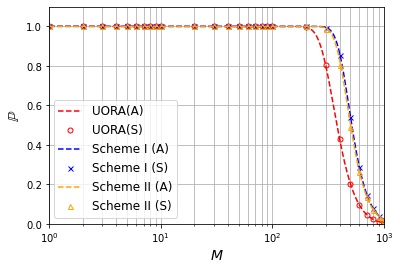

In [25]:
# print(ps_list[4])
# general
plt.semilogx(m_list, ps_list[4], linestyle = '--', color='red', label='UORA(A)')
plt.semilogx(m_list_simu, ps_list_simu_148, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.semilogx(m_list, ps_list_random[4], linestyle = '--', color='blue', label='Scheme I (A)')
plt.semilogx(m_list_simu, ps_list_simu_148_random, label='Scheme I (S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping
plt.semilogx(m_list, ps_list_ramp[4], linestyle = '--', color='orange', label='Scheme II (A)')
plt.semilogx(m_list_simu, ps_list_simu_148_ramp, label='Scheme II (S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

# plt.title('$R=148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$\mathbb{P}$", fontsize = 15)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.3), fontsize = 12)
plt.axis([1,sta_max,0.0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

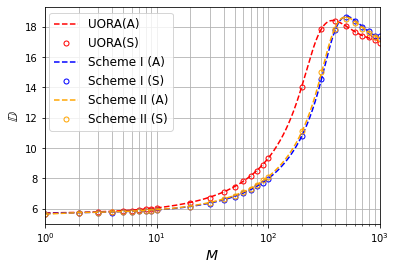

In [26]:
# general
plt.semilogx(m_list, da_list[4], linestyle = '--', color='red', label='UORA(A)')
plt.semilogx(m_list_simu, da_list_simu_148, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.semilogx(m_list, da_list_random[4], linestyle = '--', color='blue', label='Scheme I (A)')
plt.semilogx(m_list_simu, da_list_simu_148_random, label='Scheme I (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping
plt.semilogx(m_list, da_list_ramp[4], linestyle = '--', color='orange', label='Scheme II (A)')
plt.semilogx(m_list_simu, da_list_simu_148_ramp, label='Scheme II (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$\mathbb{D}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.7), fontsize = 12)
plt.xlim(1, sta_max)
# plt.axis([1,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

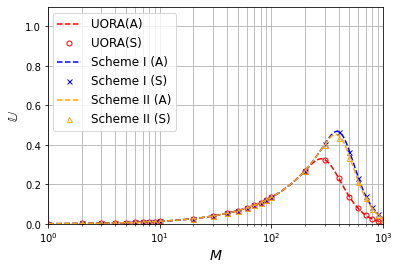

In [27]:
# print(ps_list[4])
# general
plt.semilogx(m_list, u_list[4], linestyle = '--', color='red', label='UORA(A)')
plt.semilogx(m_list_simu, u_list_simu_148, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.semilogx(m_list, u_list_random[4], linestyle = '--', color='blue', label='Scheme I (A)')
plt.semilogx(m_list_simu, u_list_simu_148_random, label='Scheme I (S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping 
plt.semilogx(m_list, u_list_ramp[4], linestyle = '--', color='orange', label='Scheme II (A)')
plt.semilogx(m_list_simu, u_list_simu_148_ramp, label='Scheme II (S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$\mathbb{U}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.7), fontsize = 12)
plt.axis([1,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

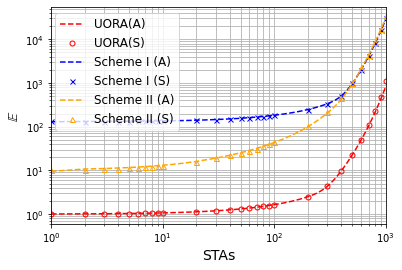

In [28]:
# print(ps_list[4])
# general
plt.plot(m_list, power_list[4], linestyle = '--', color='red', label='UORA(A)')
plt.plot(m_list_simu, power_list_simu_148, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.plot(m_list, power_list_random[4], linestyle = '--', color='blue', label='Scheme I (A)')
plt.plot(m_list_simu, power_list_simu_148_random, label='Scheme I (S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping
plt.plot(m_list, power_list_ramp[4], linestyle = '--', color='orange', label='Scheme II (A)')
plt.plot(m_list_simu, power_list_simu_148_ramp, label='Scheme II (S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.yscale('log')
plt.xscale('log')
# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("STAs", fontsize = 14)
plt.ylabel("$\mathbb{E}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.7), fontsize = 12)
plt.xlim(1,sta_max)
# plt.axis([10,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

# ------------------------R=9------------------------

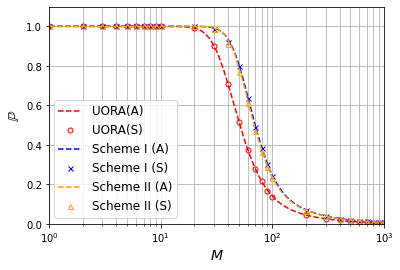

In [29]:
# print(ps_list[4])
# general
plt.semilogx(m_list, ps_list[0], linestyle = '--', color='red', label='UORA(A)')
plt.semilogx(m_list_simu, ps_list_simu_9, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.semilogx(m_list, ps_list_random[0], linestyle = '--', color='blue', label='Scheme I (A)')
plt.semilogx(m_list_simu, ps_list_simu_9_random, label='Scheme I (S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping
plt.semilogx(m_list, ps_list_ramp[0], linestyle = '--', color='orange', label='Scheme II (A)')
plt.semilogx(m_list_simu, ps_list_simu_9_ramp, label='Scheme II (S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

# plt.title('$R=148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$\mathbb{P}$", fontsize = 15)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.3), fontsize = 12)
plt.axis([1,sta_max,0.0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

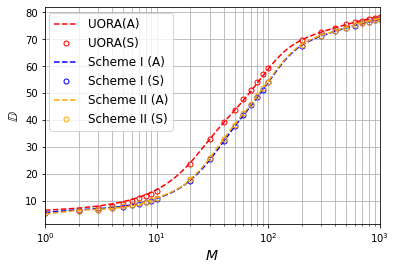

In [30]:
# general
plt.semilogx(m_list, da_list[0], linestyle = '--', color='red', label='UORA(A)')
plt.semilogx(m_list_simu, da_list_simu_9, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.semilogx(m_list, da_list_random[0], linestyle = '--', color='blue', label='Scheme I (A)')
plt.semilogx(m_list_simu, da_list_simu_9_random, label='Scheme I (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping
plt.semilogx(m_list, da_list_ramp[0], linestyle = '--', color='orange', label='Scheme II (A)')
plt.semilogx(m_list_simu, da_list_simu_9_ramp, label='Scheme II (S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$\mathbb{D}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.7), fontsize = 12)
plt.xlim(1, sta_max)
# plt.axis([1,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

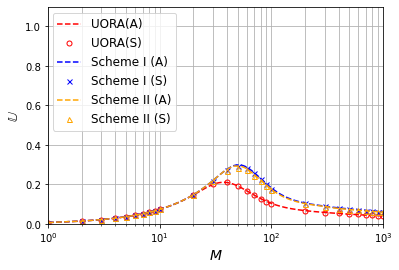

In [31]:
# print(ps_list[4])
# general
plt.semilogx(m_list, u_list[0], linestyle = '--', color='red', label='UORA(A)')
plt.semilogx(m_list_simu, u_list_simu_9, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.semilogx(m_list, u_list_random[0], linestyle = '--', color='blue', label='Scheme I (A)')
plt.semilogx(m_list_simu, u_list_simu_9_random, label='Scheme I (S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping 
plt.semilogx(m_list, u_list_ramp[0], linestyle = '--', color='orange', label='Scheme II (A)')
plt.semilogx(m_list_simu, u_list_simu_9_ramp, label='Scheme II (S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("$\mathbb{U}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.7), fontsize = 12)
plt.axis([1,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

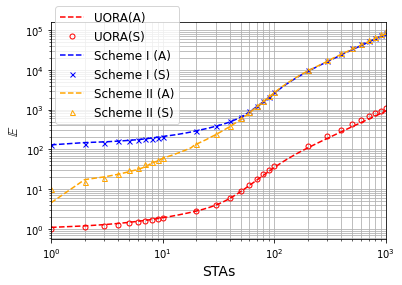

In [36]:
# print(ps_list[4])
# general
plt.plot(m_list, power_list[0], linestyle = '--', color='red', label='UORA(A)')
plt.plot(m_list_simu, power_list_simu_9, label='UORA(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

# random
plt.plot(m_list, power_list_random[0], linestyle = '--', color='blue', label='Scheme I (A)')
plt.plot(m_list_simu, power_list_simu_9_random, label='Scheme I (S)', linestyle='None', marker='x', markerfacecolor='None', markeredgecolor='blue', markersize=5)
# ramping
plt.plot(m_list, power_list_ramp[0], linestyle = '--', color='orange', label='Scheme II (A)')
plt.plot(m_list_simu, power_list_simu_9_ramp, label='Scheme II (S)', linestyle='None', marker='^', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.yscale('log')
plt.xscale('log')
# plt.title('$R = 148$' +', $L_{max} = $' + str(Lmax) + ', CR=3dB, N=4', fontsize = 18)
plt.xlabel("STAs", fontsize = 14)
plt.ylabel("$\mathbb{E}$", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.8), fontsize = 12)
plt.xlim(1,sta_max)
# plt.axis([10,sta_max,0,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()